# Single qubit GST on the 5 qubit chip (Data from 3.5.2023)

In [1]:
# Note: I removed the mGST folders from within the qibocal fork, such that it is installed and updated seperately
from mGST import compatibility,algorithm, optimization, low_level_jit, additional_fns

In [102]:
import pickle as pickle
from pygsti.report import reportables as rptbl #Needs cvxpy!
import pygsti
from argparse import Namespace
import numpy as np
import pandas as pd
import numpy.linalg as la
import json
import matplotlib.pyplot as plt
from pygsti.modelpacks import smq2Q_XYICNOT as std

%run ../src/mGST/reporting.py

### Setting the parameters

In [3]:
pdim = 4   # physical dimension
r = pdim**2   # rank of the gate superoperators 

max_l = 10  # maximum number of gates in each measurement sequence
n_povm = 4   # number of POVM-elements


### Loading data

In [4]:
with open('data/20230504-1132_cgst_depth_5.json') as f:
    data = json.load(f)
N = data['nsequences']
l = data['depth']
J5 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])
y5 = np.array([[data['measurements'][i]['hardware_probabilities'][basis_str] for i in range(N)] for basis_str in ['00','01','10','11']])

with open('data/20230504-1132_cgst_depth_7.json') as f:
    data = json.load(f)
N = data['nsequences']
l = data['depth']
J7 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])
y7 = np.array([[data['measurements'][i]['hardware_probabilities'][basis_str] for i in range(N)] for basis_str in ['00','01','10','11']])

with open('data/20230504-1132_cgst_depth_10.json') as f:
    data = json.load(f)
N = data['nsequences']
l = data['depth']
J10 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])
y10 = np.array([[data['measurements'][i]['hardware_probabilities'][basis_str] for i in range(N)] for basis_str in ['00','01','10','11']])

J57 = np.concatenate((J5,J7), axis = 0)
y57 = np.concatenate((y5,y7), axis = 1)

J_all = np.concatenate((J57,J10), axis = 0)
y_all = np.concatenate((y57,y10), axis = 1)

meas_samples = data['nshots']
d = 6

### GST

In [5]:
CZ = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]])
CZ_gate = np.kron(CZ,CZ)
X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std') #Import XYICNOT model from pygsti
X_t[[1,2,3,4],:,:] = X_t[[3,4,1,2],:,:] #swap gate ordering for consistency
X_t[5] = CZ_gate
target_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std') #Save new model with CZ instead of CNOT

Starting optimization...
0it [00:00, ?it/s]


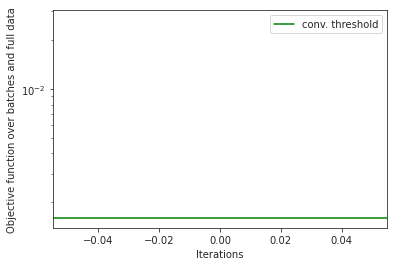

Success threshold not reached, attempting optimization over full data set...
100%|███████████████████████████████████████████| 40/40 [04:37<00:00,  6.93s/it]


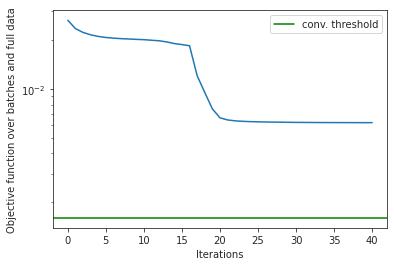

#################
	 Convergence criterion not satisfied, try increasing max_iter or using new initializations.
	 Final objective function value 0.006190394066882237 with # of initializations: 1 
 	 Total runtime: 277.7372851371765


In [7]:
bsize = 120   # The batch size on which the optimization is started
results = []
for rK in [1]:  
    K_t = additional_fns.Kraus_rep(X_t,d,pdim,rK)
    # K,X,E,rho,res_list = algorithm.run_mGST(y_all,J_all,max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'GD',
    #                      max_inits = 10, max_iter = 200, final_iter = 100, threshold_multiplyer = 100, 
    #                      target_rel_prec = 1e-4, init = [K_t, E_t, rho_t], testing = True)   
    K,X,E,rho,res_list = algorithm.run_mGST(y_all,J_all,max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                         max_inits = 10, max_iter = 0, final_iter = 40, threshold_multiplyer = 100, 
                         target_rel_prec = 1e-4, init = [K_t, E_t, rho_t], testing = True)   
    results.append([K,X,E,rho])

In [8]:
# ###################################### 
# filename = 'ranks_1_from_init'
# parameters = {'sequence length':l,'gate count':d,'Kraus ranks':[1],'phys. dimension':int(np.sqrt(r)), 'Sequence count': N, 
#               'J':J_all,'y':y_all,'threshold_multiplyer': 30, 
#                      'target_rel_prec':1e-4}
# data_to_safe = {'parameters':parameters, 'results':results}

# with open(filename, 'wb') as handle:
#     pickle.dump(data_to_safe, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Analysis

### Full rank

In [20]:
with open("ranks_16_from_init", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [32]:
K,X,E,rho = results[0][:]

X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std') #Import XYICNOT model from pygsti
X_t[5] = CZ_gate
target_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std') #Save new model with CZ instead of CNOT

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CNOT[q0-q1]"}
df_g, df_o, s_g, s_o, gauge_optimized_mdl = gauge_opt_report(
    X, E, rho, J_all, y_all, std.target_model(), weights, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances
Id,"0,99986","0,01681"
Rx(pi/2)[q0],"0,99849","0,05970"
Ry(pi/2)[q0],"0,99809","0,06256"
Rx(pi/2)[q1],"0,97763","0,14055"
Ry(pi/2)[q1],"0,97171","0,13126"
CNOT[q0-q1],"0,39582","0,99163"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.004103,0.081112,0.357838,0.519003,0.161231


(None, None)

In [31]:
print(la.eig(X[5])[0])
print(la.eig(X_t[5])[0])

[-0.47614233+4.88707512e-01j -0.21982315+5.86179272e-01j
 -0.47614233-4.88707512e-01j -0.21982315-5.86179272e-01j
 -0.16513911+3.68616699e-01j -0.28467827+1.50352605e-01j
 -0.16513911-3.68616699e-01j -0.28467827-1.50352605e-01j
  0.67946382-2.16537405e-02j  0.67946382+2.16537405e-02j
  1.        -1.65152470e-17j  0.96428296+1.51330381e-18j
  0.93264363+1.11993619e-17j  0.90182559+5.99171782e-17j
  0.85801688-1.18734338e-16j  0.82296818-3.36522631e-17j]
[ 1.+0.j  1.+0.j  1.+0.j -1.+0.j  1.+0.j  1.+0.j  1.+0.j -1.+0.j  1.+0.j
  1.+0.j  1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j  1.+0.j]


In [24]:
X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std') #Import XYICNOT model from pygsti
X_t[5] = CZ_gate
target_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std') #Save new model with CZ instead of CNOT
X_t2,E_t2,rho_t2 = compatibility.pygsti_model_to_arrays(target_mdl,basis = 'std') #Import XYICNOT model from pygsti

In [27]:
X_pp, E_pp, rho_pp =  compatibility.std2pp(X_t, E_t, rho_t)

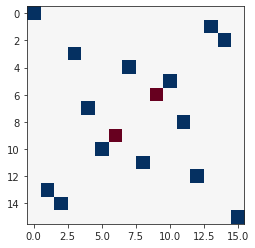

In [28]:
plt.imshow(np.real(X_pp[5]))

### Rank 4

In [76]:
with open("ranks_4_from_init", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [74]:
K,X,E,rho = results[0][:]
weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5':1, 'spam': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CNOT[q0-q1]"}
df_g, df_o, s_g, s_o, gauge_optimized_mdl = gauge_opt_report(
    X, E, rho, J_all, y_all, std.target_model(), weights, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances
Id,"0,98466","0,04937"
Rx(pi/2)[q0],"0,97743","0,08424"
Ry(pi/2)[q0],"0,97419","0,09495"
Rx(pi/2)[q1],"0,94806","0,16792"
Ry(pi/2)[q1],"0,95052","0,15220"
CNOT[q0-q1],"0,41406","0,99818"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.003927,0.079855,0.357838,0.674016,1.113629


(None, None)

### Rank 1

In [80]:
with open("ranks_16_from_init", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [82]:
K,X,E,rho = results[0][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5':1,'spam': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}
df_g, df_o, s_g, s_o, gauge_optimized_mdl = gauge_opt_report(
    X, E, rho, J_all, y_all, target_mdl, weights, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances
Id,"0,99985","0,01413"
Rx(pi/2)[q0],"0,99280","0,07295"
Ry(pi/2)[q0],"0,99327","0,06827"
Rx(pi/2)[q1],"0,96335","0,16810"
Ry(pi/2)[q1],"0,96233","0,13692"
CZ[q0-q1],"0,37913","0,97309"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.004028,0.080832,0.221379,0.112840,0.081675


(None, None)

In [18]:
print(np.diag(X_pp[5]))

[ 0.98727787+0.j         -0.41130006+0.89463762j  0.97316195+0.17819167j
 -0.15480539+0.97651381j -0.41130006-0.89463762j  0.98203783+0.j
 -0.24394814-0.95608092j  0.94937554-0.26653638j  0.97316195-0.17819167j
 -0.24394814+0.95608092j  0.99140929+0.j          0.02365688+0.99049228j
 -0.15480539-0.97651381j  0.94937554+0.26653638j  0.02365688-0.99049228j
  0.99014063+0.j        ]


### Gate plots

In [129]:
%run ../src/mGST/reporting.py

In [130]:
print(E_pp.shape)

ERROR! Session/line number was not unique in database. History logging moved to new session 298
(4, 16)


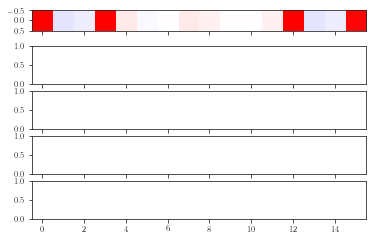

In [ ]:
plot_spam(rho_pp, E_pp)

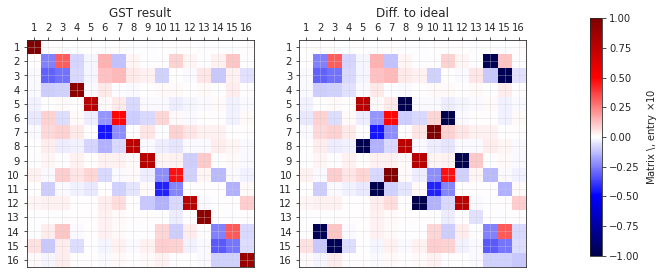

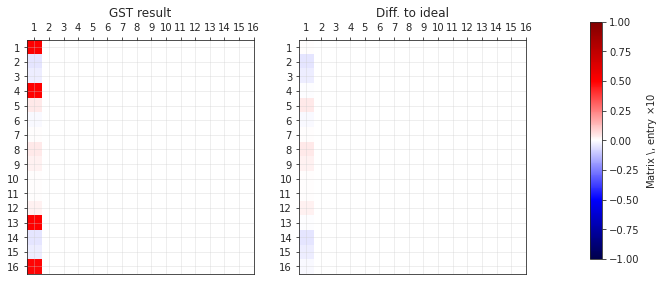

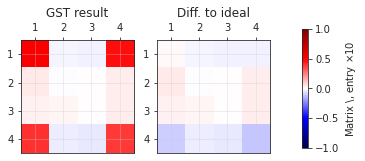

In [101]:
gate_index = 5

X_opt_pp, E_opt_pp, rho_opt_pp = compatibility.pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'pp')
X_t_pp, E_t_pp, rho_t_pp = compatibility.pygsti_model_to_arrays(target_mdl,basis = 'pp')

X_opt, E_opt, rho_opt = compatibility.pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'std')

plot_diff(X_opt_pp[gate_index], X_t_pp[gate_index])


plot_diff(rho_pp.reshape(16,1), rho_t_pp.reshape(16,1))
plot_diff(E_pp[0].reshape(4,4), E_t_pp[0].reshape(4,4))

In [43]:
X_pp, E_pp, rho_pp = compatibility.pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'std')
X_1 = np.einsum('ijkj->ik',X_pp[5].reshape(pdim,pdim,pdim,pdim))
print(np.trace(X_pp[5]))

(6.223147159151103+0j)


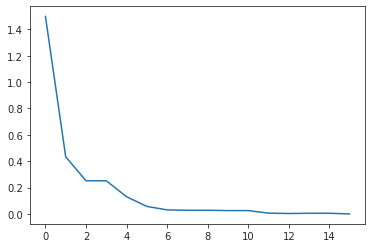

In [85]:
X_choi = X_pp.reshape(d,pdim,pdim,pdim,pdim)
X_choi = np.einsum('ijklm->iljmk',X_choi).reshape(d,pdim**2,pdim**2)
plt.plot(np.abs(la.eig(X_choi[5])[0]))

In [54]:
K_t = additional_fns.Kraus_rep(X_pp,d,pdim,1)

In [66]:
print(np.diag(np.abs(K_t[5][0])))
print(np.diag(np.angle(K_t[5][0]))/np.pi)

[0.99905541 0.98159285 0.98181258 1.        ]
[ 0.         -0.54167898 -0.06593531 -0.64586971]


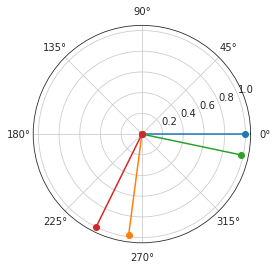

In [78]:
for x in np.diag(K_t[5][0]):
    plt.polar([0,np.angle(x)],[0,abs(x)],marker='o')
plt.show()

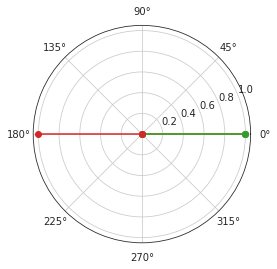

In [79]:
for x in np.diag(CZ):
    plt.polar([0,np.angle(x)],[0,abs(x)],marker='o')
plt.show()

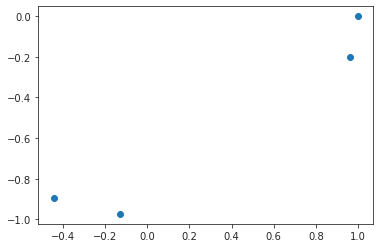

In [68]:
fig,ax = plt.subplots()
ax.scatter(np.diag(K_t[5][0]).real,np.diag(K_t[5][0]).imag)

In [87]:
print(np.abs(K_t[5][0]))

[[9.99055410e-01 3.62478608e-02 2.39661036e-02 7.90989237e-05]
 [3.17143609e-02 9.81592847e-01 1.88333966e-01 7.58309848e-06]
 [2.97065799e-02 1.87514202e-01 9.81812580e-01 1.31917695e-05]
 [7.87776278e-05 1.20152264e-05 1.17424695e-05 9.99999997e-01]]


In [97]:
from qiskit.quantum_info import entanglement_of_formation

X_choi = X_std.reshape(d,pdim,pdim,pdim,pdim)
X_choi = np.einsum('ijklm->iljmk',X_choi).reshape(d,pdim**2,pdim**2)

Help on function entanglement_of_formation in module qiskit.quantum_info.states.measures:

entanglement_of_formation(state)
    Calculate the entanglement of formation of quantum state.
    
    The input quantum state must be either a bipartite state vector, or a
    2-qubit density matrix.
    
    Args:
        state (Statevector or DensityMatrix): a 2-qubit quantum state.
    
    Returns:
        float: The entanglement of formation.
    
    Raises:
        QiskitError: if the input state is not a valid QuantumState.
        QiskitError: if input is not a bipartite QuantumState.
        QiskitError: if density matrix input is not a 2-qubit state.



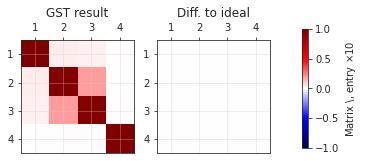

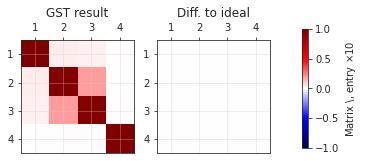

In [92]:
plot_diff(np.abs(K_t[5][0]), np.abs(K_t[5][0]))
plot_diff(np.abs(K_t[5][0]@CZ.T.conj()), np.abs(K_t[5][0]))

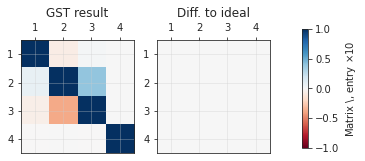

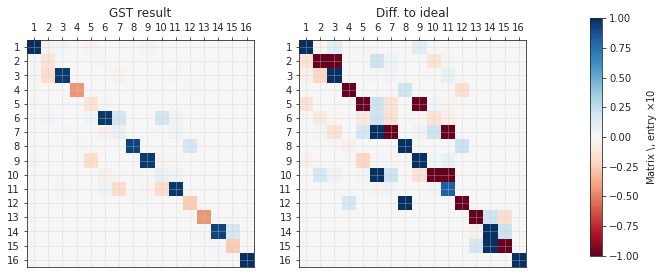

In [37]:
plot_diff(X_1, X_1)
plot_diff(X_pp[5], np.kron(X_1,X_1))